<h1 style="font-size:30px;">Image Registration using Homography and Feature Matching</h1>

In this notebook we will take a look at a concrete example of how homography and image warping can be used to align a photo of a scanned form to a template of the form. This process is generally referred to as image alignment or image registration and has numerous applications.

The multi-step process includes the following steps:

* Keypoint detection and feature extraction (in both images)
* Keypoint matching (between the two images)
* Computing the homography that relates the two images
* Using the homograhy to warp the perspective of the original image

<br>
<center>
<img src="https://opencv.org/wp-content/uploads/2021/09/c0-m11-11-04-feature-image.png" alt="c0-m11-11-04-feature-image.png">
</center>
<br>

# 1. Geometric Transformations: Review of Theory

<br>
<center>
<img src="https://opencv.org/wp-content/uploads/2021/09/c0-m11-motion-models.jpg" alt="c0-m11-motion-models.jpg">
</center>
<br>

## 1.1 Homography
* A **Homography** transforms a square/rectangle to an arbitrary quadrilateral.
* Images of two planes are related by a **Homography**.
* We need a minimum of **4 corresponding points** to estimate a Homography.

<br>
<center>
<img src="https://opencv.org/wp-content/uploads/2021/09/c0-m11-homography-example.jpg" alt="c0-m11-homography-example.jpg">
</center>
<br>

# 2. Implementation

In [1]:
if 'google.colab' in str(get_ipython()):
    print("Downloading Code to Colab Environment")
    !wget https://www.dropbox.com/sh/vuiu1n95x2q6q7q/AAANt6Y9G_e5WwsqbXTaqtqza?dl=1 -O module-code.zip -q --show-progress
    !unzip -qq module-code.zip
    !pip install --upgrade opencv-python
else:
    pass

In [2]:
# Import Libraries.
import cv2
import numpy as np
import matplotlib.pyplot as plt

## 2.1 Read and Display Images of Scanned Form and Template

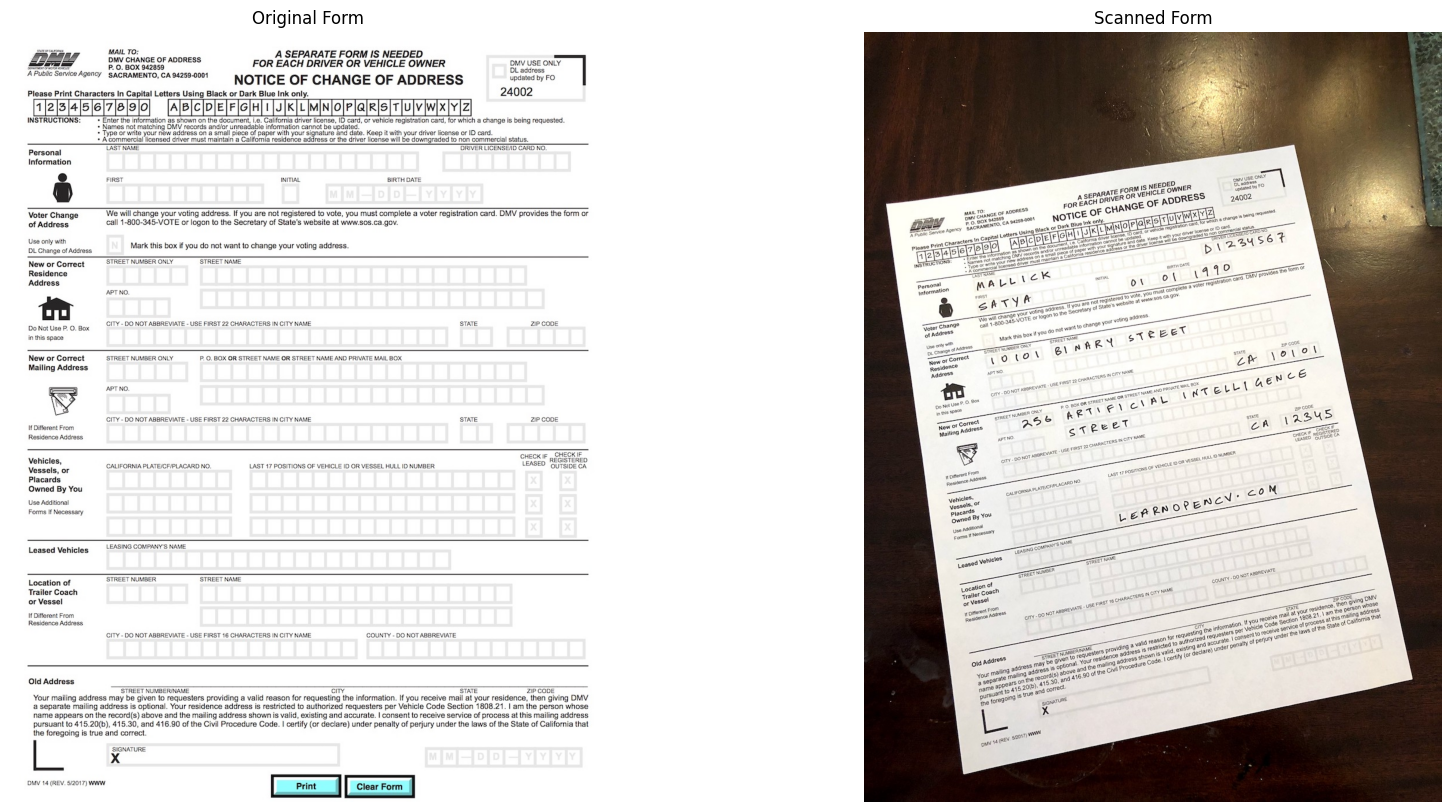

In [3]:
# Read reference image of the form.
img_form = 'form.jpg'
img_form = cv2.imread(img_form, cv2.IMREAD_COLOR)

# Read image of the scanned form to be aligned.
img_scan = "scanned-form.jpg"
img_scan = cv2.imread(img_scan, cv2.IMREAD_COLOR)

# Display the images.
plt.figure(figsize = [20, 10])
plt.subplot(121); plt.axis('off'); plt.imshow(img_form[:, :, ::-1]); plt.title("Original Form")
plt.subplot(122); plt.axis('off'); plt.imshow(img_scan[:, :, ::-1]); plt.title("Scanned Form");

## 2.2 Find Keypoints in Both Images

The ORB class in OpenCV implements the ORB (Oriented FAST and Rotated BRIEF) keypoint detector and descriptor extractor. Think of keypoints as points within each image that are associated with well-defined corners that are stable under image transformations. Each keypoint has an associated feature descriptor vector. Keypoints and Descriptors can be computed using `detectAndCompute()`. The keypoints themselves can be drawn on the image using a function called `drawKeypoints()`.

### <font color="green">OpenCV Documentation</font>

[**`ORB (Oriented FAST and Rotated BRIEF) Tutorial`**](https://docs.opencv.org/4.5.2/d1/d89/tutorial_py_orb.html)

[**`FAST (Algorithm for Corner Detection) Tutorial`**](https://docs.opencv.org/3.4/df/d0c/tutorial_py_fast.html)

[**`BRIEF (Binary Robust Independent Elementary Features) Tutorial`**](https://docs.opencv.org/3.4/dc/d7d/tutorial_py_brief.html)
<hr style="border:none; height: 4px; background-color:#D3D3D3" />

## ORB Class
<hr style="border:none; height: 4px; background-color:#D3D3D3" />

### <font color="green">Function Syntax</font>
```python
retval = cv2.ORB_create([, nfeatures[, scaleFactor[, nlevels[, edgeThreshold[, firstLevel[, WTA_K[, scoreType[, patchSize[, fastThreshold]]]]]]]]])
```

### <font color="green">OpenCV Documentation</font>

[**`ORB Class Reference`**](https://docs.opencv.org/4.5.2/db/d95/classcv_1_1ORB.html)

## Keypoints and Descriptor  Extraction

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

### <font color="green">Function Syntax</font>
```python
keypoints, descriptors = cv.Feature2D.detectAndCompute(image, mask[, descriptors[, useProvidedKeypoints]])


```
The function has **2 required argument**:

1. `image`: Input image.
2. `mask`: Input mask (but this can be specified as `None`).

### <font color="green">OpenCV Documentation</font>


[**`detectAndCompute()`**](https://docs.opencv.org/4.5.2/d0/d13/classcv_1_1Feature2D.html#a8be0d1c20b08eb867184b8d74c15a677)


## Drawing Keypoints

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

### <font color="green">Function Syntax</font>
```python
outImage = cv2.drawKeypoints(image, keypoints, outImage[, color[, flags]])
```
The function has **3 required argument**:

1. `image`: Source image.
2. `keypoints`: Keypoints from the source image.
3. `outImage`: Can be specified as `None` if using return value from function.

### <font color="green">OpenCV Documentation</font>


[**`drawKeypoints()`**](https://docs.opencv.org/4.5.2/d4/d5d/group__features2d__draw.html#ga5d2bafe8c1c45289bc3403a40fb88920)

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

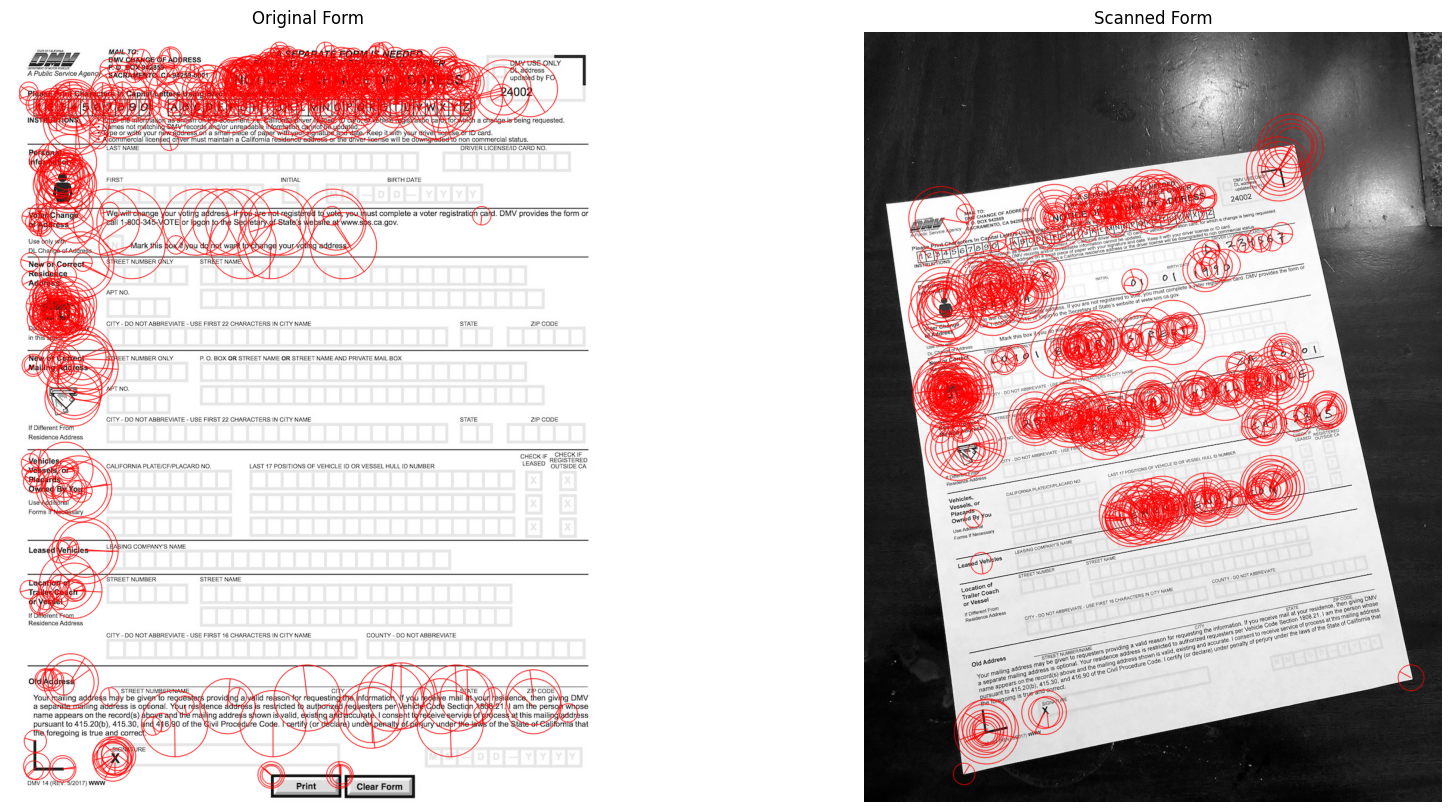

In [4]:
# Convert images to grayscale.
img_form_gray = cv2.cvtColor(img_form, cv2.COLOR_BGR2GRAY)
img_scan_gray = cv2.cvtColor(img_scan, cv2.COLOR_BGR2GRAY)

# Detect keypoints and compute descriptors.
orb = cv2.ORB_create(nfeatures = 600)
keypoints1, descriptors1 = orb.detectAndCompute(img_form_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(img_scan_gray, None)

# Draw the keypoints in both images.
img_form_keypoints = cv2.drawKeypoints(img_form_gray, keypoints1, None,
                                       color = (255, 0, 0), flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_scan_keypoints = cv2.drawKeypoints(img_scan_gray, keypoints2, None,
                                       color = (255, 0, 0), flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display the images with the keypoints.
plt.figure(figsize = [20,10])
plt.subplot(121); plt.axis('off'); plt.imshow(img_form_keypoints); plt.title("Original Form")
plt.subplot(122); plt.axis('off'); plt.imshow(img_scan_keypoints); plt.title("Scanned Form");

### <font style="color:rgb(50,120,230)">Examine a keypoint and its associated descriptor</font>

In [5]:
idx = 0
print(img_form_gray.shape)
print ("")
print ("Template Form:")
print ("")
print ("keypoint angle: ", keypoints1[idx].angle)
print ("keypoint size:  ", keypoints1[idx].size)
print ("keypoint x:     ", keypoints1[idx].pt[0])
print ("keypoint y:     ", keypoints1[idx].pt[1])
print ("")
print ("Descriptor: ", descriptors1[idx])
print ("")

print ("Scanned Form:")
print ("")
print ("keypoint angle: ", keypoints2[idx].angle)
print ("keypoint size:  ", keypoints2[idx].size)
print ("keypoint x:     ", keypoints2[idx].pt[0])
print ("keypoint y:     ", keypoints2[idx].pt[1])
print ("")
print ("Descriptor: ", descriptors2[idx])
print ("")

(1293, 1000)

Template Form:

keypoint angle:  258.64752197265625
keypoint size:   31.0
keypoint x:      651.0
keypoint y:      120.0

Descriptor:  [ 29 122 159 163  50 111 179  92  10 205 181 230  62  86 195  34 190  93
 198 117 131 227  40  76 248 133  47 166 233 123  35 241]

Scanned Form:

keypoint angle:  271.52325439453125
keypoint size:   31.0
keypoint x:      762.0
keypoint y:      662.0

Descriptor:  [ 86  78 222 181   2   2  45  35 180 146 194 131  93  35  49  75 103 197
  59 168  96 201   1 204 208 162 254 132 165 240  33   8]



### <font style="color:rgb(50,120,230)">Plot two random descriptors</font>

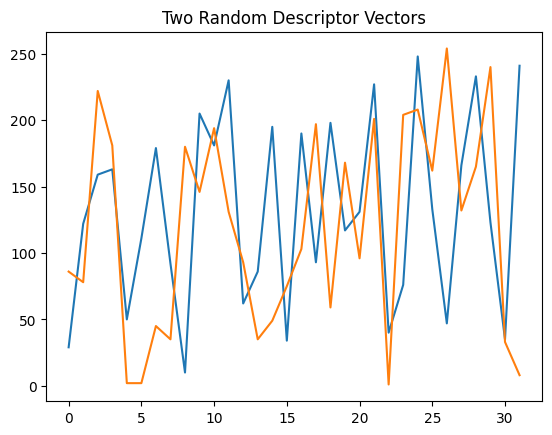

In [6]:
d1 = descriptors1[0] # Form
d2 = descriptors2[0] # Scan
plt.plot(d1)
plt.plot(d2)
plt.title("Two Random Descriptor Vectors");

## 3.3 Match Keypoints in the Two Images

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

**`DescriptorMatcher_create()`** Creates a descriptor matcher of a given type with the default parameters (using default constructor).

### <font color="green">Function Syntax </font>
``` python
retval = cv2.DescriptorMatcher_create(descriptorMatcherType)
```

The function has **1 required argument**:

1. `descriptorMatcherType`: Descriptor matcher type.

### <font color="green">OpenCV Documentation</font>


[**`DescriptorMatcher Class Reference`**](https://docs.opencv.org/4.5.2/db/d39/classcv_1_1DescriptorMatcher.html)

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

### <font color="green">Function Syntax </font>
``` python
matches = cv.DescriptorMatcher.match(queryDescriptors, trainDescriptors[, mask])
```

The function has **2 required argument**:


1. `queryDescriptors`: Query set of descriptors.
2. `trainDescriptors`: Train set of descriptors. This set is not added to the train descriptors collection stored in the class object.


### <font color="green">OpenCV Documentation</font>

[**`match()`**](https://docs.opencv.org/4.5.2/db/d39/classcv_1_1DescriptorMatcher.html#a0f046f47b68ec7074391e1e85c750cba)

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

In [7]:
# Match features.
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)

matches = matcher.match(descriptors1, descriptors2, None)

# Sort matches by score.
matches = sorted(matches, key = lambda x: x.distance, reverse = False)

# Retain only the top 10% of matches.
numGoodMatches = int(len(matches) * 0.10)
matches = matches[:numGoodMatches]

### <font style="color:rgb(50,120,230)">Print BEST keypoint and descriptor vector from each image</font>

In [8]:
idx = 0 # First index for best match.

qdx = matches[idx].queryIdx
tdx = matches[idx].trainIdx

print ("")
print ("keypoint angle: ", keypoints1[qdx].angle)
print ("keypoint size:  ", keypoints1[qdx].size)
print ("keypoint x:     ", keypoints1[qdx].pt[0])
print ("keypoint y:     ", keypoints1[qdx].pt[1])
print ("")
print ("descriptor1: ", descriptors1[qdx])
print ("")

print ("")
print ("keypoint angle: ", keypoints2[tdx].angle)
print ("keypoint size:  ", keypoints2[tdx].size)
print ("keypoint x:     ", keypoints2[tdx].pt[0])
print ("keypoint y:     ", keypoints2[tdx].pt[1])
print ("")
print ("descriptor2: ", descriptors2[tdx])
print ("")


keypoint angle:  283.39520263671875
keypoint size:   64.28160858154297
keypoint x:      89.16481018066406
keypoint y:      238.4640350341797

descriptor1:  [ 25 207  66 172 148 147 207 245  68   4  92 230  97  99 179 196  88 106
   6 238 201 186  36 189 168 229 166 128  63 154 248 168]


keypoint angle:  278.00213623046875
keypoint size:   44.6400032043457
keypoint x:      139.6800079345703
keypoint y:      460.8000183105469

descriptor2:  [ 57 207  66 174 148 147 207 245  68   4  92 230 113 225 179 196 124 106
   6 238 201 186  36 189 224 205 166 128  63 186 248 168]



### <font style="color:rgb(50,120,230)">Plot the descriptors for the BEST keypoint match</font>

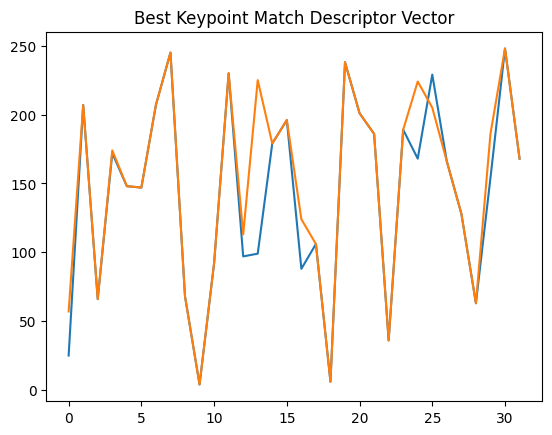

In [9]:
idx = 0 # First index for best match.
d1 = descriptors1[matches[idx].queryIdx]
d2 = descriptors2[matches[idx].trainIdx]
plt.plot(d1)
plt.plot(d2)
plt.title("Best Keypoint Match Descriptor Vector");

<br>
<center>
<img src="https://opencv.org/wp-content/uploads/2021/09/c0-m11-hamming-distance.png" alt="c0-m11-hamming-distance.png" width="450" height="200" align="left">
</center>
<br>

### Hamming Distance between two Descriptor

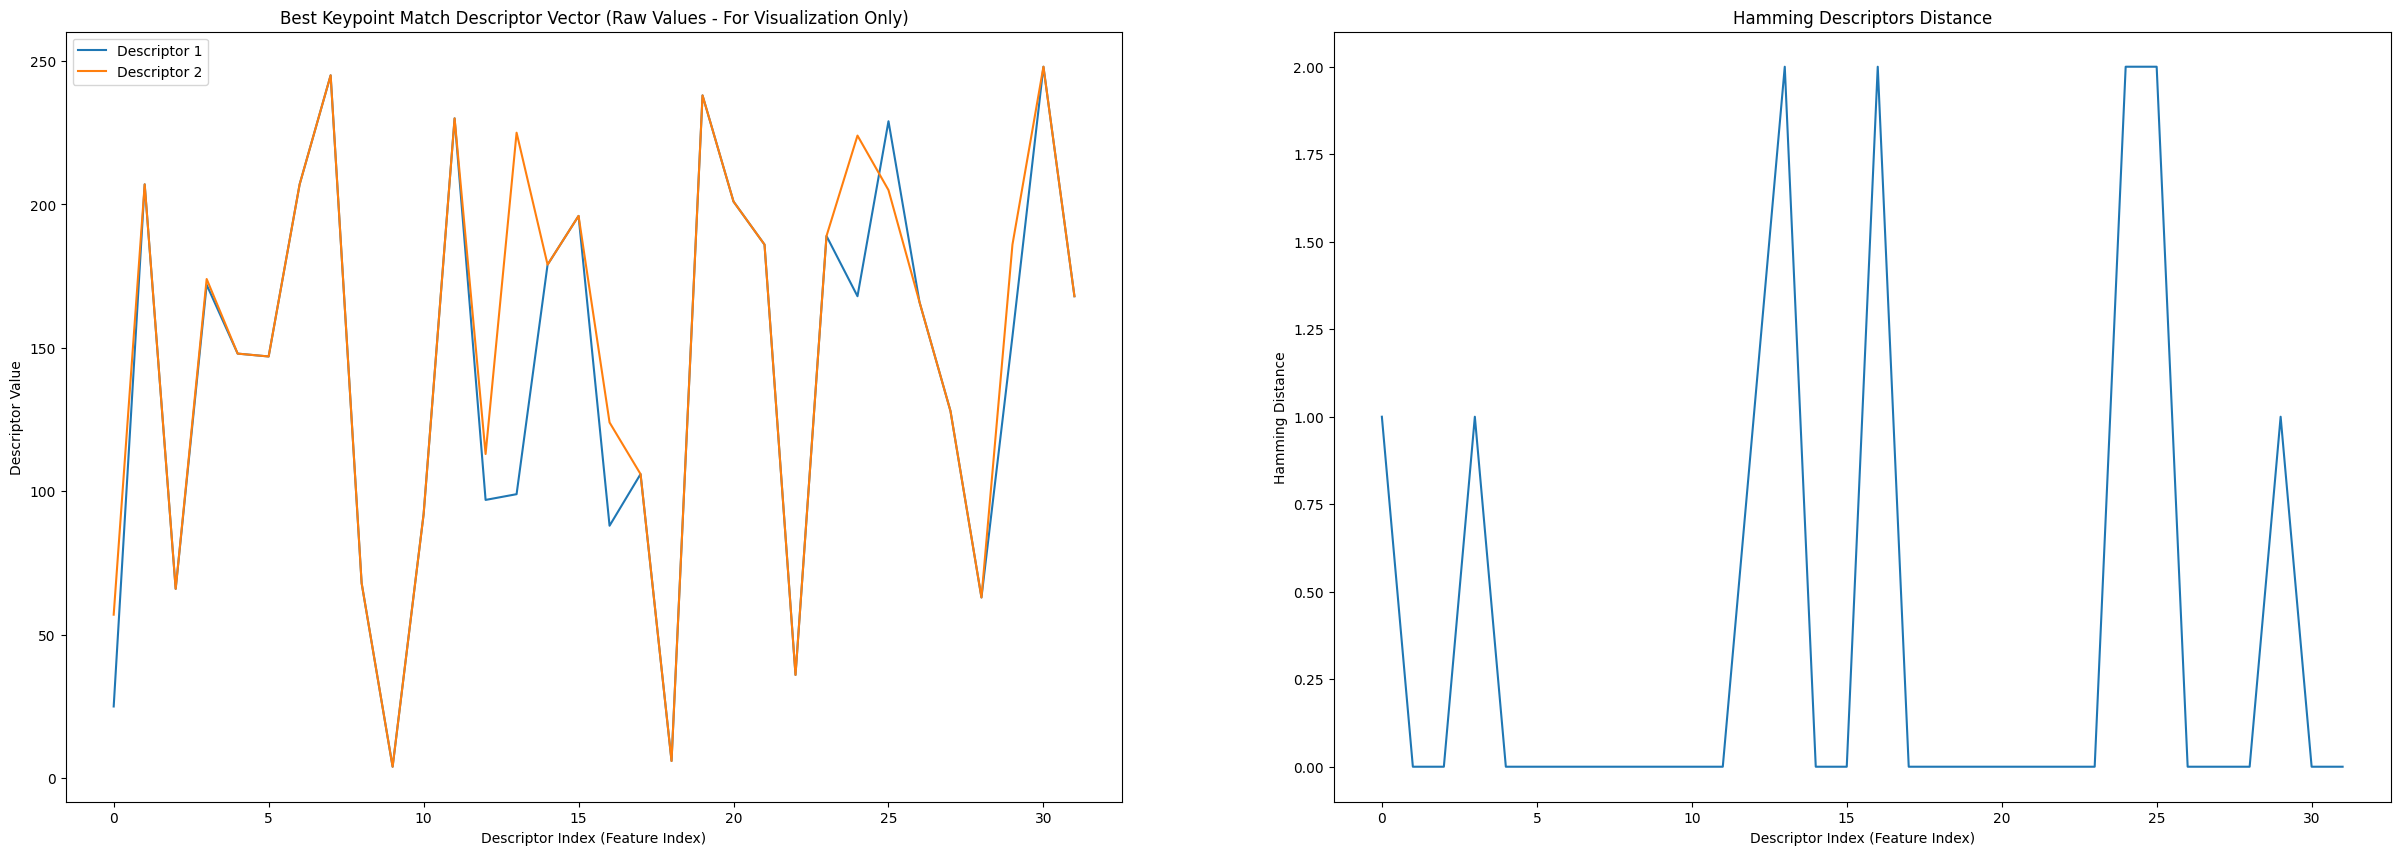

In [10]:
'''
Visualization of raw descriptor values (for reference only).
ORB descriptors are binary patterns, but here we are plotting their decimal representations.
This plot does NOT indicate similarity, as ORB matching is based on Hamming distance, which is visualized in the next plot.
'''

# Calculate Hamming distance for each keypoint descriptor
hamm_match_dist_per_key = []
for iDes in range(len(d1)):
    hamm_match_dist_per_key.append(bin(d1[iDes] ^ d2[iDes]).count('1'))

# Display the final results
plt.figure(figsize=[30, 10])

# First plot - Descriptor vectors
plt.subplot(121)
plt.plot(d1, label='Descriptor 1')
plt.plot(d2, label='Descriptor 2')
plt.title("Best Keypoint Match Descriptor Vector (Raw Values - For Visualization Only)")
plt.xlabel("Descriptor Index (Feature Index)")  # X-axis: Descriptor index
plt.ylabel("Descriptor Value")  # Y-axis: Descriptor valu
plt.legend()

# Second plot - Hamming descriptor distances
plt.subplot(122)
plt.plot(hamm_match_dist_per_key)
plt.xlabel("Descriptor Index (Feature Index)")  # X-axis: Descriptor index
plt.ylabel("Hamming Distance")  # Y-axis: Hamming distance
plt.title("Hamming Descriptors Distance")

# Show the plots
plt.show()

### <font style="color:rgb(50,120,230)">Draw the matches of the corresponding keypoints</font>

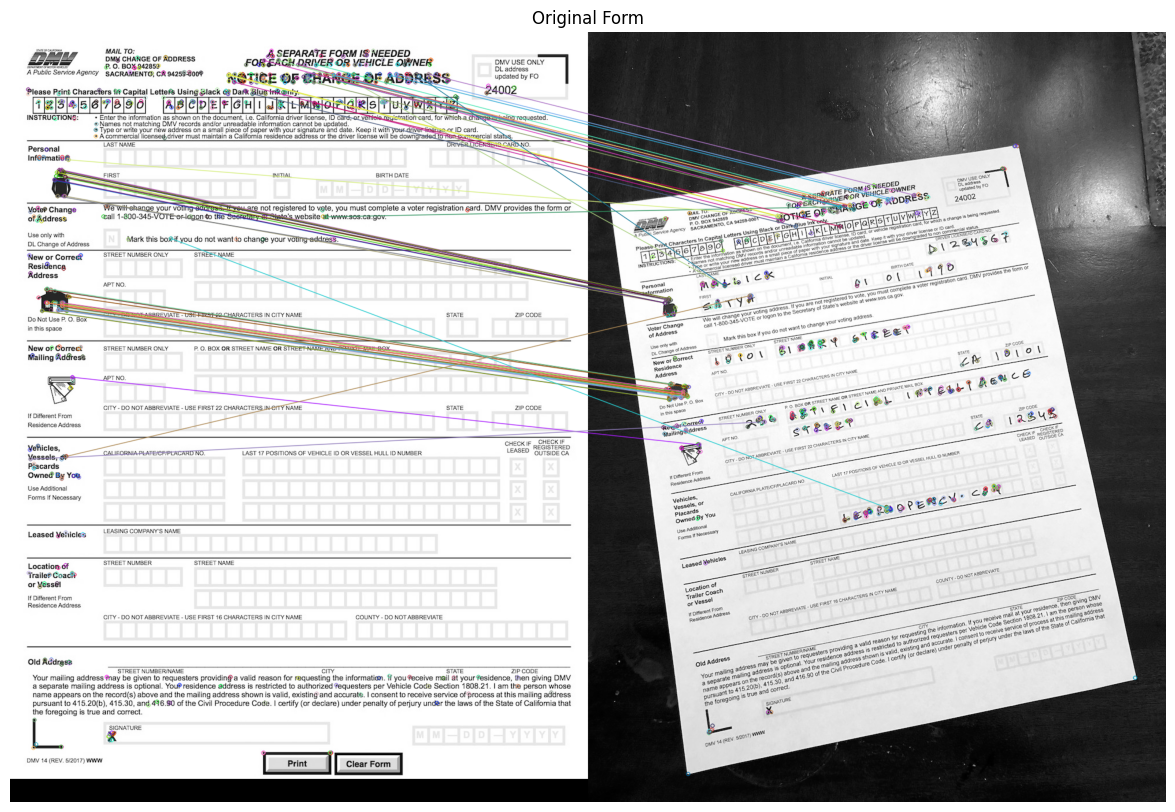

In [11]:
# Draw top matches.
im_matches = cv2.drawMatches(img_form_gray, keypoints1, img_scan_gray, keypoints2, matches, None)

plt.figure(figsize = [40,10])
plt.imshow(im_matches); plt.axis('off'); plt.title("Original Form");

## 2.4 Find the Homography

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

**`findHomography()`** Finds a perspective transformation between two planes.

### <font color="green">Function Syntax </font>
``` python
retval, mask = cv2.findHomography(srcPoints, dstPoints[, method[, ransacReprojThreshold[, mask[, maxIters[, confidence]]]]])
```

`retval`: Homography for the perspective transformation.


The function has **2 required arguments**:

1. `srcPoints`:	Coordinates of the points in the original plane, a matrix of the type CV_32FC
2. `dstPoints`: Coordinates of the points in the original plane, a matrix of the type CV_32FC

### <font color="green">OpenCV Documentation</font>


[**`findHomography`**](https://docs.opencv.org/4.5.2/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780)

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

In [12]:
# Extract the location of good matches.
points1 = np.zeros((len(matches), 2), dtype = np.float32)
points2 = np.zeros((len(matches), 2), dtype = np.float32)

for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

## 2.5 Warp the Scanned Form

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

**`warpPerspective()`** Applies a perspective transformation to an image.

### <font color="green">Function Syntax </font>
``` python
dst = cv2.warpPerspective(src, M, dsize[, dst[, flags[, borderMode[, borderValue]]]])
```

`dst`: output image that has the size dsize and the same type as src.

The function has **3 required arguments**:

1. `src`:	input image.
2. `M`: 	3×3 transformation matrix.
3. `dsize`:	size of the output image.

### <font color="green">OpenCV Documentation</font>


[**`warpPerspective`**](https://docs.opencv.org/4.5.2/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87)

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

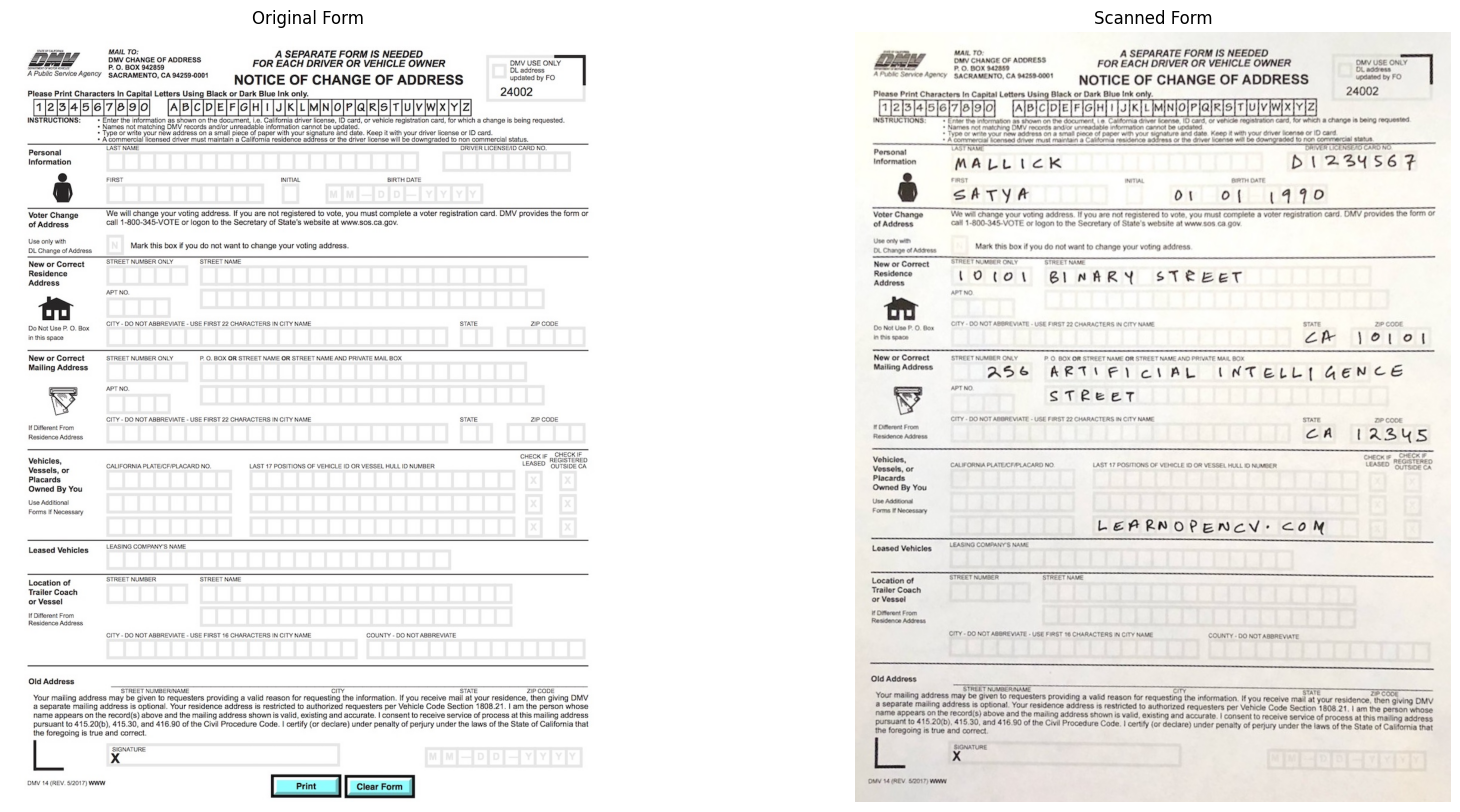

In [13]:
# Use the homography to warp the scanned image.
height, width, channels = img_form.shape
img_scan_reg = cv2.warpPerspective(img_scan, h, (width, height))

# Display the final results.
plt.figure(figsize = [20,10])
plt.subplot(121); plt.imshow(img_form[:, :, ::-1]);     plt.axis('off'); plt.title("Original Form")
plt.subplot(122); plt.imshow(img_scan_reg[:, :, ::-1]); plt.axis('off'); plt.title("Scanned Form");

In [14]:
print(cv2.__version__)

4.10.0
